<html>
  <body>
    <header></header>
        <CENTER>
          <img src="https://www.uvv.br/wp-content/themes/uvvBr/templates/assets//img/logouvv.svg" alt="UVV-LOGO" style = width="10px"; height="100px">
        </CENTER>
        <h1 style="font-size:1vw">
        <CENTER><b>ANÁLISE EXPLORATÓRIA DOS DADOS</b></CENTER>
        <CENTER><b>ANÁLISE DE REGRESSÃO - OUTROS MODELOS</b></CENTER>
  </body>
</html>

**NOME:**: Dylan Faria Robson

**LINK PARA ESTE NOTEBOOK:** [Aqui!](https://colab.research.google.com/drive/1y58OlEfed9YdATfsEssk5wZ9hYev9h3W?usp=sharing)

# BIBLIOTECAS E FUNÇÕES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Bibliotecas para o Modelo Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [ ]:
import scipy
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Discretização
def discretizar(dataset, column):
  '''
  DOCSTRING:
  dataset: nome do dataset
  column: 'example'
  Cria um dataframe com o nome t{numero da coluna}. Ex.: t1. Ele contem a relação entre as variaveis qualitarivas antes e depois da discretização.
  Para saber o numero da coluna a função: dataset.columns.get_loc('column')

  Return:
  dataframe com a relação 'Qualitativa' e 'Discretizada'.
  dataset com a coluna 'column' discretizada.

  '''
  #Função para fazer a discretização de variaveis qualitativas
  unique = dataset[column].unique()
  _qualitativa = []
  _discretizada = []

  for i in range(0, len(unique)):
      _qualitativa.append(unique[i])
      _discretizada.append(i)

  dataframe = pd.DataFrame(columns=["Qualitativa", "Discretizada"], data=list(zip(_qualitativa, _discretizada)))


  frequencias = dataset[column].value_counts()

  # Criar um dicionário de mapeamento de categoria para valor numérico

  mapeamento = {categoria: indice for indice, categoria in enumerate(frequencias.index)}

  # Aplicar o mapeamento para criar a nova coluna discreta

  dataset[column] = dataset[column].map(mapeamento)

  # Nome da coluna com a relação Pandas Series String e ndArray = t{numero da coluna no dataset}. Ex.: t1
  n_coluna = dataset.columns.get_loc(column)

  _str = f"t{n_coluna}"
  globals()[_str] = dataframe
  return globals()[_str]


In [ ]:
def separar_train_validation_test(dataset, X_, y_):
  '''
  DOCSTRING:
  dataset: nome do dataset
  X: ['example1', 'example2'] - Entradas descretizadas
  y = ['example'] - alvo
  Faz o processo de criação do dataset X e y para treino,  teste e validação , assim como
  o modelo treinado, testado e validado.

  Return:
  X e y utilizado no treino, teste e validação.
  '''


  # Separar: [X]
  X = dataset[X_]

  # Transformando Pandas Series em ndArray
  X = np.array(X)

  #Separa [y]
  y = dataset[y_]

  # Transformando Pandas Series em ndArray
  y = np.array(y)

  # Modelo Escolhido: Training 60%, Validation 20% e Test 20%
  X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)
  # Cross Validation
  for i in range(10):

    # Treinamento = 60% + (Validação + Teste) = 40%
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=.25, shuffle = True)


  return  X_train_validation, X_test, y_train_validation, y_test, y, X, X_train, X_validation, y_train, y_validation

In [ ]:
def analyseResidual(resids):
  #plt.set_size_inches(17,10)
  plt.plot(resids)
  plt.xlabel('Amostras')
  plt.ylabel(f'Erro: $\\epsilon$ = {resids.mean(): .3f}')
  plt.title('Análise do resíduo: $\\epsilon = y_{real} - y_{estimado}$')
  plt.hlines(resids.mean(), 0, len(resids), color='red')
  plt.show()


In [ ]:
# Continuando celula anterior:
def residuals(clf, X, y, r_type='standardized'):
    """Calculate residuals or standardized residuals.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    r_type : str
        Type of residuals to return: 'raw', 'standardized', 'studentized'.
        Defaults to 'standardized'.

        * 'raw' will return the raw residuals.
        * 'standardized' will return the standardized residuals, also known as
          internally studentized residuals, which is calculated as the residuals
          divided by the square root of MSE (or the STD of the residuals).
        * 'studentized' will return the externally studentized residuals, which
          is calculated as the raw residuals divided by sqrt(LOO-MSE * (1 -
          leverage_score)).

    Returns
    -------
    numpy.ndarray
        An array of residuals.
    """
    # Make sure value of parameter 'r_type' is one we recognize
    assert r_type in ('raw', 'standardized', 'studentized'), (
        "Invalid option for 'r_type': {0}".format(r_type))
    y_true = y.view(dtype='float')
    # Use classifier to make predictions
    y_pred = clf.predict(X)
    # Make sure dimensions agree (Numpy still allows subtraction if they don't)
    assert y_true.shape == y_pred.shape, (
        "Dimensions of y_true {0} do not match y_pred {1}".format(y_true.shape,
                                                                  y_pred.shape))
    # Get raw residuals, or standardized or standardized residuals
    resids = y_pred - y_true
    if r_type == 'standardized':
        resids = resids / np.std(resids)
    elif r_type == 'studentized':
        # Prepare a blank array to hold studentized residuals
        studentized_resids = np.zeros(y_true.shape[0], dtype='float')
        # Calcluate hat matrix of X values so you can get leverage scores
        hat_matrix = np.dot(
            np.dot(X, np.linalg.inv(np.dot(np.transpose(X), X))),
            np.transpose(X))
        # For each point, calculate studentized residuals w/ leave-one-out MSE
        for i in range(y_true.shape[0]):
            # Make a mask so you can calculate leave-one-out MSE
            mask = np.ones(y_true.shape[0], dtype='bool')
            mask[i] = 0
            loo_mse = np.average(resids[mask] ** 2, axis=0)  # Leave-one-out MSE
            # Calculate studentized residuals
            studentized_resids[i] = resids[i] / np.sqrt(
                loo_mse * (1 - hat_matrix[i, i]))
        resids = studentized_resids
    return resids

def adj_r2_score(clf, X, y):
    """Calculate the adjusted :math:`R^2` of the model.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].

    Returns
    -------
    float
        The adjusted :math:`R^2` of the model.
    """
    n = X.shape[0]  # Number of observations
    p = X.shape[1]  # Number of features
    r_squared = metrics.r2_score(y, clf.predict(X))
    return 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))


In [ ]:
def questao5():
  """
  DOCSTRING:
  Faz uma previsão utilizando o modelo o modelo de regressão linear 'regression'
  Utiliza as tabelas da relação 'Qualitativa' e 'Discretizada' criada na função 'discretizar'

  Return:
  Faz o print dos valores gerados de X e a previsão de y do modelo supracitado.
  """

  i = 0
  while True:

    option = int(input('1 - Prever, 0 - Parar\nSua Opção: '))
    if option == 0:
      print('\nEncerrando...\nPronto!')
      break
    if option == 1:
      i+=1
      # Amostra nova por Simulação: sample [x0,	x1,	x2,	x3]


      x0 = round(int(np.random.normal(X[:, 0].mean(), X[:, 0].std(), 1)[0]), 2)
      x1 = round(int(np.random.randint(0, 2, 1)[0]),2)
      #x2 = round(int(np.random.randint(0, 2, 1)[0]), 2)
      x3 = round(int(np.random.normal(X[:, 2].mean(), X[:, 2].std(), 1)[0]), 2)
      x4 = round(np.random.normal(X[:, 3].mean(), X[:, 3].std(), 1)[0], 2)

      if x0 <0:
        x0 = -x0
      elif x3 <0:
        x3 = -x3

      # Amostra nova por Simulação: sample1
      sample = np.array([x0, x1, x3, x4])

      # Amostra nova: sample1 aplicar ao Modelo Linear
      y = md_regr2.predict(sample.reshape(1, -1))
      y_estimado = y[0]
      #print(sample)




      # Voltando Discretização

      regiao = t1['Qualitativa'][x0]
      sexo = t2['Qualitativa'][x1]
      #estado_civil = t2['Qualitativa'][x2]
      dia = t3['Qualitativa'][x3]

      #Print
      print("\n---------------------------------")
      print(f"Cliente {i}")
      print(f"Região: {regiao}\nSexo: {sexo}\nDia: {dia}\nSalário Bruto: {x4: .2f}")
      print(f'VALOR ESTIMADO: R${y_estimado: .2f}\n')

    else:
      print('Opção não dispónivel')
      break

In [ ]:
# Questão 4
def questao4(y_test, resids, hue):
  """
  DOCSTRING:
  y_test: ndArray utilizado para testar os valores de y.
  resids: residuos retornados da função summary
  hue: variavel que deve ser explicada através da utilização de legendas e cores

  Return:
  Grafico jointplot com relação y_test e resids
  """

  plt = sns.jointplot(x = y_test.ravel(), y = resids, hue=hue, kind='kde')
  #Colocando Titulo
  plt.fig.suptitle("JointPlot - Analise residual por regressão")
  plt.ax_joint.collections[0].set_alpha(0)
  plt.fig.tight_layout()
  plt.fig.subplots_adjust(top=0.95)
  #Colocando X e Y Labels
  plt.set_axis_labels('Amostras', 'Residuo', fontsize=16)

#LOAD

In [ ]:
# LOAD DO DATASET
dataset = pd.read_csv('/content/table3.csv', index_col = 0)
discretizar(dataset, 'REGIÃO')
discretizar(dataset, 'SEXO')
discretizar(dataset, 'DIA')
dataset

,CÓDIGO,REGIÃO,SEXO,DIA,SALÁRIO BRUTO (R$),TOTAL DE GASTOS (R$)
0,3378,1,0,1,4278.422505,17.142316
1,8657,1,0,0,5793.003135,657.742664
2,9891,2,0,0,3607.919786,5.398043
3,1743,0,0,0,4479.150188,54.459833
4,4212,1,1,0,4100.578219,17.028375
...,...,...,...,...,...,...
4995,5694,2,1,0,4580.181796,43.275137
4996,8074,0,1,0,4099.572499,12.066558
4997,1193,0,1,0,5350.885963,183.956860
4998,3338,0,0,0,4567.149396,41.542448


In [ ]:
del dataset['CÓDIGO']

In [ ]:
dataset.columns

Index(['REGIÃO', 'SEXO', 'DIA', 'SALÁRIO BRUTO (R$)', 'TOTAL DE GASTOS (R$)'], dtype='object')

Para uma variável **quantitativa contínua: TOTAL DE GASTOS (R$)**, faça:

#Questão 1:

Faça o ajuste (FIT) dos 3 regressores por validação cruzada (10 vezes)

In [ ]:
# Separar (split) os conjuntos: TRAIN - VALIDATION - TEST
X_train_validation, X_test, y_train_validation, y_test, y, X, X_train, X_validation, y_train, y_validation = separar_train_validation_test(dataset, ['REGIÃO', 'SEXO', 'DIA', 'SALÁRIO BRUTO (R$)'], ['TOTAL DE GASTOS (R$)'])

#Normalização de variaveis X e y para melhorar o desempenho do treinamento do modelo SVR
scaling_X = MinMaxScaler(feature_range=(-1,1)).fit(np.array(dataset[['REGIÃO', 'SEXO', 'DIA', 'SALÁRIO BRUTO (R$)']]))
scaling_y = MinMaxScaler(feature_range=(-1,1)).fit(np.array(dataset[['TOTAL DE GASTOS (R$)']]))

X_train_normal = scaling_X.transform(X_train)
y_train_normal = scaling_y.transform(y_train)
X_test_normal = scaling_X.transform(X_test)
y_test_normal = scaling_y.transform(y_test)


In [ ]:
# REGRESSOR 1:
regr1 = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)

# REGRESSOR 2:
rng = np.random.RandomState(1)
regr2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)

# REGRESSOR 3:
regr3 = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)



for i in range(0, 10):
  md_regr1 = regr1.fit(X_train, y_train.ravel())
  md_regr2 = regr2.fit(X_train, y_train.ravel())
  md_regr3 = regr3.fit(X_train_normal, y_train_normal.ravel())

#Questão 2:

Faça o relatório gráfico de Análise de Residual do conjunto: TEST

In [ ]:
#Rediduo
resids_regr1 = residuals(md_regr1, X_test, y_test.ravel(), r_type='raw')
resids_regr2 = residuals(md_regr2, X_test, y_test.ravel(), r_type='raw')
resids_regr3 = residuals(md_regr3, X_test_normal, y_test_normal.ravel(), r_type='raw')

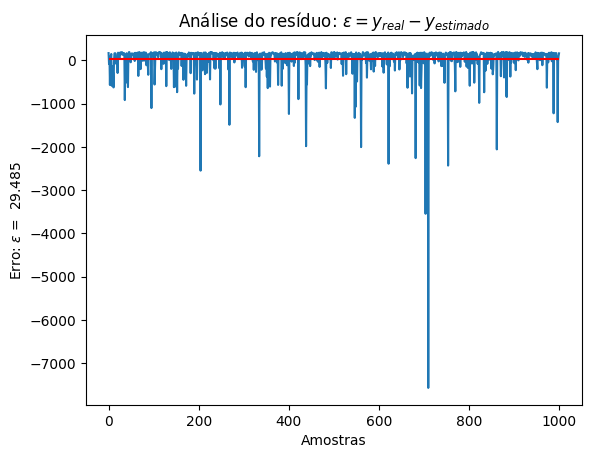

In [ ]:
analyseResidual(resids_regr1)

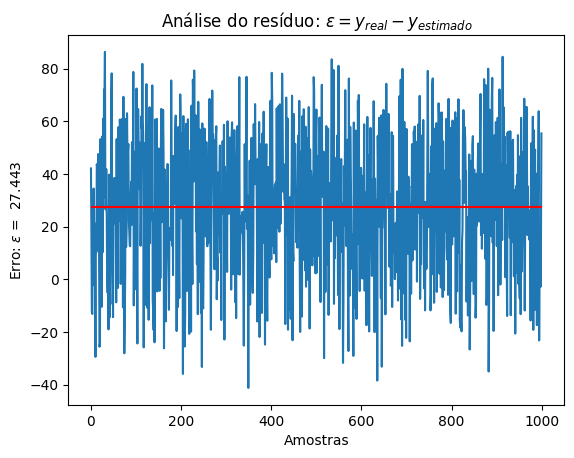

In [ ]:
analyseResidual(resids_regr2)

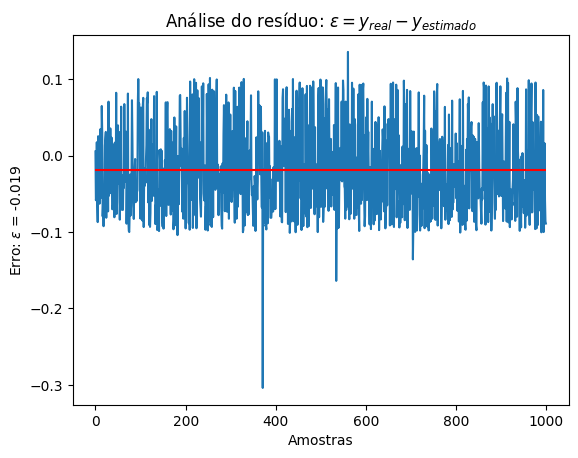

In [ ]:
analyseResidual(resids_regr3)

#Questão 3:

Faça o relatório de Análise da métrica: Coeficiente de Determinação $R^2$

In [ ]:
print(f'R2 modelo 1 = {round(adj_r2_score(md_regr1, X_test, y_test.ravel()), 2)}')

R2 modelo 1 = 0.06


In [ ]:
print(f'R2 modelo 2 = {round(adj_r2_score(md_regr2, X_test, y_test.ravel()), 2)}')

R2 modelo 2 = 0.99


In [ ]:
print(f'R2 modelo 3 = {round(adj_r2_score(md_regr3, X_test, y_test.ravel()), 2)}')

R2 modelo 3 = -1.0892481205984195e+17


#Questão 4:

Faça o gráfico de Análise Residual (jointplot) por regressão

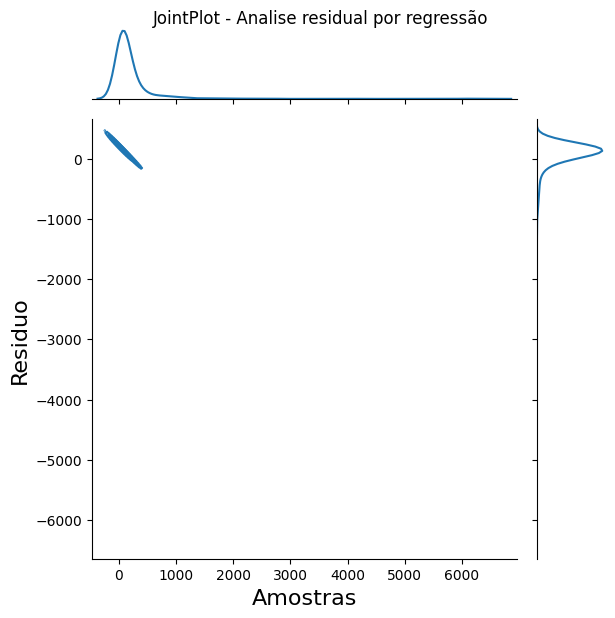

In [ ]:
# Modelo 1
questao4(y_test, resids_regr1, hue=None)

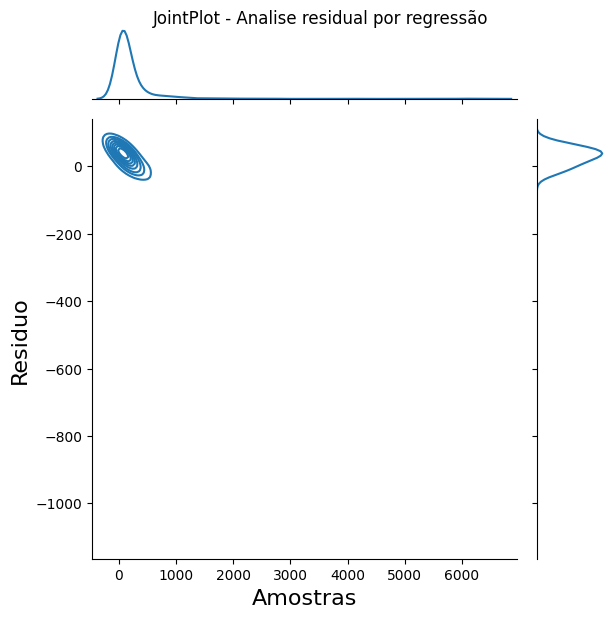

In [ ]:
# Modelo 2
questao4(y_test, resids_regr2, hue=None)

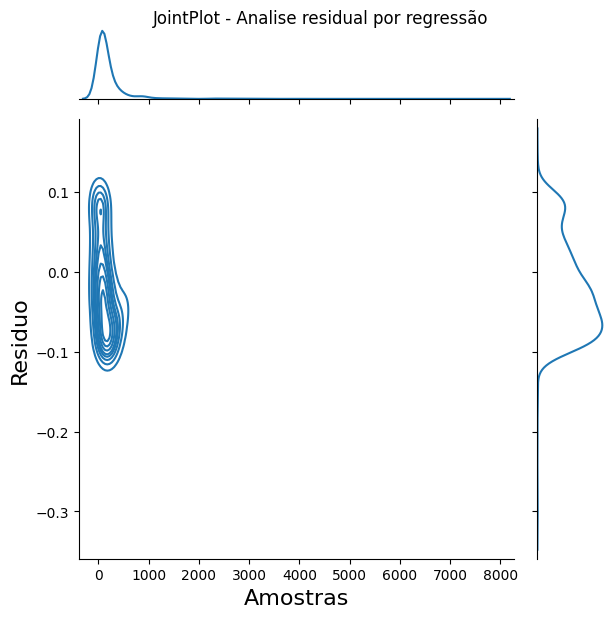

In [ ]:
#Modelo 3
questao4(y_test, resids_regr3, hue=None)

#Questão 5:

Faça a simulação: Regressor de maior SCORE dos dados exibindo TODAS as informações do cliente + Gasto estimado:

In [ ]:
questao5()

1 - Prever, 0 - Parar
Sua Opção: 1

---------------------------------
Cliente 1
Região: NORDESTE
Sexo: MASCULINO
Dia: SEXTA-FEIRA
Salário Bruto:  5015.81
VALOR ESTIMADO: R$ 127.53

1 - Prever, 0 - Parar
Sua Opção: 1

---------------------------------
Cliente 2
Região: NORTE
Sexo: FEMININO
Dia: SEXTA-FEIRA
Salário Bruto:  4730.33
VALOR ESTIMADO: R$ 88.92

1 - Prever, 0 - Parar
Sua Opção: 1

---------------------------------
Cliente 3
Região: SUDESTE
Sexo: MASCULINO
Dia: SÁBADO
Salário Bruto:  4369.33
VALOR ESTIMADO: R$ 88.92

1 - Prever, 0 - Parar
Sua Opção: 1

---------------------------------
Cliente 4
Região: NORTE
Sexo: MASCULINO
Dia: SEXTA-FEIRA
Salário Bruto:  5050.38
VALOR ESTIMADO: R$ 127.54

1 - Prever, 0 - Parar
Sua Opção: 1

---------------------------------
Cliente 5
Região: NORDESTE
Sexo: FEMININO
Dia: SÁBADO
Salário Bruto:  5073.03
VALOR ESTIMADO: R$ 133.55

1 - Prever, 0 - Parar
Sua Opção: 1

---------------------------------
Cliente 6
Região: NORDESTE
Sexo: FEMININO
Dia:

#Extra

In [ ]:
dataset.corr('spearman')

,REGIÃO,SEXO,DIA,SALÁRIO BRUTO (R$),TOTAL DE GASTOS (R$)
REGIÃO,1.000000,0.008409,-0.000952,-0.014578,-0.017249
SEXO,0.008409,1.000000,0.005227,0.023137,0.015806
DIA,-0.000952,0.005227,1.000000,-0.009222,-0.007634
SALÁRIO BRUTO (R$),-0.014578,0.023137,-0.009222,1.000000,0.961320
TOTAL DE GASTOS (R$),-0.017249,0.015806,-0.007634,0.961320,1.000000


#CONCLUSÕES:


1.   A partir da analise do R$^2$ e residuos é possivel concluir que o conjunto de dados apresenta um melhor ajuste ao segundo modelo: 'AdaBoostRegressor', com o maior score e menor residuo.

2. Como o algoritimo 'AdaBoostRegressor' escolhido utiiza o regressor 'DecisionTreeRegressor', por si só não é possivel compreender as caracteristicas que o dataset apresentam. Não obstante, a partir da analise da correlação utilizando o coeficiente 'spearman', podemos definir que existe uma relação monótona crescente muito forte entre as variaveis X - SALÁRIO BRUTO (R\\$) e y - TOTAL DE GASTOS (R$).

PARA ENTREGAR: Coverter seu YPYNB para PDF:

In [ ]:
%%shell
jupyter nbconvert --to html /content/Análise_de_Regressão_II.ipynb

[NbConvertApp] Converting notebook /content/Análise_de_Regressão_II.ipynb to html
[NbConvertApp] Writing 974448 bytes to /content/Análise_de_Regressão_II.html
